<a href="https://colab.research.google.com/github/claudeshyaka/Real-Time_Machine_Learning/blob/main/MordernCNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Claude Shyaka
## ID# 801263243
## Real-Time Machine Learning -- ModernCNNs

In [1]:
!pip install -q d2l==1.0.0-beta0

%matplotlib inline
import time
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.nn import functional as F
from d2l import torch as d2l

d2l.use_svg_display()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 30.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.8 MB/s eta 0:00:00


# Helper Methods

In [2]:
class Trainer(d2l.HyperParameters):
    """The base class for training models with data.

    Defined in :numref:`subsec_oo-design-models`"""
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)


    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        raise NotImplementedError

    def prepare_batch(self, batch):
        """Defined in :numref:`sec_linear_scratch`"""
        return batch

    def fit_epoch(self):
        """Defined in :numref:`sec_linear_scratch`"""
        self.model.train()
        for batch in self.train_dataloader:
            loss = self.model.training_step(self.prepare_batch(batch))
            self.optim.zero_grad()
            with torch.no_grad():
                loss.backward()
                if self.gradient_clip_val > 0:  # To be discussed later
                    self.clip_gradients(self.gradient_clip_val, self.model)
                self.optim.step()
            self.train_batch_idx += 1
        if self.val_dataloader is None:
            return
        self.model.eval()
        for batch in self.val_dataloader:
            with torch.no_grad():
                self.model.validation_step(self.prepare_batch(batch))
            self.val_batch_idx += 1

    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        """Defined in :numref:`sec_use_gpu`"""
        self.save_hyperparameters()
        self.gpus = [d2l.gpu(i) for i in range(min(num_gpus, d2l.num_gpus()))]
    

    def prepare_batch(self, batch):
        """Defined in :numref:`sec_use_gpu`"""
        if self.gpus:
            batch = [d2l.to(a, self.gpus[0]) for a in batch]
        return batch

    def prepare_model(self, model):
        """Defined in :numref:`sec_use_gpu`"""
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        if self.gpus:
            model.to(self.gpus[0])
        self.model = model

    def clip_gradients(self, grad_clip_val, model):
        """Defined in :numref:`sec_rnn-scratch`"""
        params = [p for p in model.parameters() if p.requires_grad]
        norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
        if norm > grad_clip_val:
            for param in params:
                param.grad[:] *= grad_clip_val / norm

In [3]:
# Additional functions and method to initialize the model and 
# extend the trainer.

# define training step to include accuracy measurement.
@d2l.add_to_class(d2l.Classifier)
def training_step(self, batch):
  Y_hat = self(*batch[:-1])
  l = self.loss(Y_hat, batch[-1])
  self.plot('loss', l, train=True)
  self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=True)
  return l

# Model Initializer
def init_cnn(module):
  """Initialize weights for CNNs"""
  if type(module) == nn.Linear or type(module) == nn.Conv2d:
    nn.init.xavier_uniform_(module.weight)

@d2l.add_to_class(d2l.Module)
def apply_init(self, inputs, init=None):
    self.forward(*inputs)
    if init is not None:
        self.net.apply(init)

# Exetend the trainer to train on gpu
@d2l.add_to_class(d2l.Trainer)
def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
    self.save_hyperparameters()
    self.gpus = [d2l.gpu(i) for i in range(min(num_gpus, d2l.num_gpus()))]

# Prepare batch for gpu training.
@d2l.add_to_class(d2l.Trainer)
def prepare_batch(self, batch):
    if self.gpus:
        batch = [d2l.to(a, self.gpus[0]) for a in batch]
    return batch

@d2l.add_to_class(d2l.Trainer)
def prepare_model(self, model):
    model.trainer = self
    model.board.xlim = [0, self.max_epochs]
    if self.gpus:
        model.to(self.gpus[0])
    self.model = model

@d2l.add_to_class(d2l.Trainer)
def fit(self, model, data):
    self.prepare_data(data)
    self.prepare_model(model)
    self.optim = model.configure_optimizers()
    self.epoch = 0
    self.train_batch_idx = 0
    self.val_batch_idx = 0
    for self.epoch in range(self.max_epochs):
        self.fit_epoch()

@d2l.add_to_class(d2l.Trainer)
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

# Loading CIFAR-10 Dataset

In [4]:
# define a class to download and read the CIFAR-10 Dataset
class CIFAR10(d2l.DataModule):
  """The CIFAR-10 dataset"""
  def __init__(self, batch_size=64, resize=(32, 32)):
    super().__init__()
    self.save_hyperparameters()
    trans = transforms.Compose([transforms.Resize(resize),
                               transforms.ToTensor()])
    self.train = torchvision.datasets.CIFAR10(
        root=self.root, train=True, transform=trans, download=True)
    self.val = torchvision.datasets.CIFAR10(
            root=self.root, train=False, transform=trans, download=True)

# Convenience method to converts between numeric labels and their names.
@d2l.add_to_class(CIFAR10)
def text_labels(self, indices):
    """Return text labels."""
    labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
              'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [labels[int(i)] for i in indices]
    
# Reading a minibatch
@d2l.add_to_class(CIFAR10)
def get_dataloader(self, train):
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=self.num_workers)

# A convenience function used to visualize the images 
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        try:
            img = img.detach().numpy()
        except:
            pass
        ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

@d2l.add_to_class(CIFAR10)
def visualize(self, batch, nrows=1, ncols=8, labels=[]):
    X, y = batch
    if not labels:
        labels = self.text_labels(y)
    d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)


# Problem 1 - VGG network 

In [5]:
# defining a VGG block
def vgg_block(num_convs, out_channels):
  layers=[]
  for _ in range(num_convs):
    layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
    layers.append(nn.ReLU())
  layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
  return nn.Sequential(*layers)

# define a VGG class that extends the d2l.Classifier
class VGG(d2l.Classifier):
  def __init__(self, arch, lr=0.1, num_classes=10):
    super().__init__()
    self.save_hyperparameters()
    conv_blks = []
    for (num_convs, out_channels) in arch:
      conv_blks.append(vgg_block(num_convs, out_channels))
    self.net = nn.Sequential(
        *conv_blks, nn.Flatten(),
        nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
        nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
        nn.LazyLinear(num_classes))
    self.net.apply(d2l.init_cnn)
    

In [6]:
# Data
data_CIFAR10 = CIFAR10(batch_size=128, resize=(64, 64))
# Trainer
trainer_vgg = Trainer(max_epochs=10, num_gpus=2) 

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


112.07 sec


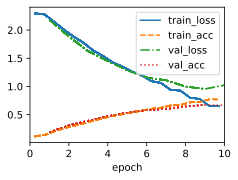

In [7]:
# VGG-11 used in class from the VGG paper (Simonyan and Zisserman, 2014) 
modelVGG11 = VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512)), 
                 lr=0.1)
modelVGG11.apply_init([next(iter(data_CIFAR10.get_dataloader(True)))[0]], 
                 d2l.init_cnn)
# Train 11
tic = time.time()
trainer_vgg.fit(modelVGG11, data_CIFAR10)
print(f'{time.time() - tic:.2f} sec')

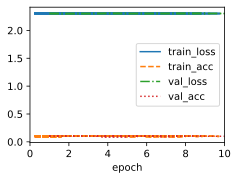

In [8]:
# VGG-16
modelVGG16 = VGG(arch=((2, 64), (2, 128), (3, 256), (3, 512), (3, 512)), 
                 lr=0.5)
modelVGG16.apply_init([next(iter(data_CIFAR10.get_dataloader(True)))[0]], 
                 d2l.init_cnn)
# Train 16
trainer_vgg.fit(modelVGG16, data_CIFAR10)

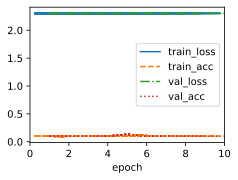

In [9]:
# VGG-19
modelVGG19 = VGG(arch=((2, 64), (3, 128), (4, 256), (4, 512), (4, 512)), 
                 lr=0.1)
modelVGG19.apply_init([next(iter(data_CIFAR10.get_dataloader(True)))[0]], 
                 d2l.init_cnn)
# Train 19
trainer_vgg.fit(modelVGG19, data_CIFAR10)

In [10]:
# complexity and model size
!pip install -q ptflops

  Preparing metadata (setup.py) ... done


In [11]:
from ptflops import get_model_complexity_info

with torch.cuda.device(0):  
  nets = [modelVGG11, modelVGG16, modelVGG19]
  for net in nets:
    macs, params = get_model_complexity_info(net, (3, 64, 64), 
                      as_strings=True, print_per_layer_stat=False, 
                      verbose=False)
    print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
    print('{:<30}  {:<8}'.format('Number of parameters: ', params))
    print('---------------------')

Computational complexity:       637.99 MMac
Number of parameters:           34.44 M 
---------------------
Computational complexity:       1.28 GMac
Number of parameters:           39.93 M 
---------------------
Computational complexity:       1.77 GMac
Number of parameters:           45.39 M 
---------------------


# Problem 2 - Google Net

### Google Net trained on CIFAR10

In [12]:
# define the inception block
class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
  def __init__(self, c1, c2, c3, c4, **kwargs):
      super(Inception, self).__init__(**kwargs)
      # Branch 1
      self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
      # Branch 2
      self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
      self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
      # Branch 3
      self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
      self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
      # Branch 4
      self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
      self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

  def forward(self, x):
      b1 = F.relu(self.b1_1(x))
      b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
      b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
      b4 = F.relu(self.b4_2(self.b4_1(x)))
      return torch.cat((b1, b2, b3, b4), dim=1)

# Google Net Module Piece by piece
class GoogleNet(d2l.Classifier):
  # First block
  def b1(self):
    return nn.Sequential(
      nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
      nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
# Second block
@d2l.add_to_class(GoogleNet)
def b2(self):
  return nn.Sequential(
    nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
    nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
# Third block
@d2l.add_to_class(GoogleNet)
def b3(self):
  return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
    Inception(128, (128, 192), (32, 96), 64),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
# Fourth block
@d2l.add_to_class(GoogleNet)
def b4(self):
  return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
    Inception(160, (112, 224), (24, 64), 64),
    Inception(128, (128, 256), (24, 64), 64),
    Inception(112, (144, 288), (32, 64), 64),
    Inception(256, (160, 320), (32, 128), 128),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
# Fifth block
@d2l.add_to_class(GoogleNet)
def b5(self):
  return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
    Inception(384, (192, 384), (48, 128), 128),
    nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())
# Piece everything together
@d2l.add_to_class(GoogleNet)
def __init__(self, lr=0.1, num_classes=10):
  super(GoogleNet, self).__init__()
  self.save_hyperparameters()
  self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                            self.b5(), nn.LazyLinear(num_classes))
  self.net.apply(d2l.init_cnn)

In [13]:
trainerGoogleNet = Trainer(max_epochs=10, num_gpus=2)
data = CIFAR10(batch_size=128, resize=(64, 64))

Files already downloaded and verified
Files already downloaded and verified


180.02 sec


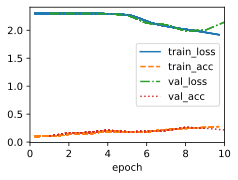

In [14]:
modelGoogleNet = GoogleNet(lr=0.01)
modelGoogleNet.apply_init([next(iter(data.get_dataloader(True)))[0]], 
                          d2l.init_cnn)
tic = time.time()
trainerGoogleNet.fit(modelGoogleNet, data)
print(f'{time.time() - tic:.2f} sec')

In [15]:
with torch.cuda.device(0):  
  nets = [modelGoogleNet]
  for net in nets:
    macs, params = get_model_complexity_info(net, (3, 64, 64), 
                      as_strings=True, print_per_layer_stat=False, 
                      verbose=False)
    print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
    print('{:<30}  {:<8}'.format('Number of parameters: ', params))
    print('---------------------')

Computational complexity:       129.76 MMac
Number of parameters:           5.98 M  
---------------------


### Adding Batch Norm to GoogleNet

In [16]:
# Google Net Module Piece by piece
class BNGoogleNet(d2l.Classifier):
  # First block
  def b1(self):
    return nn.Sequential(
      nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3), 
      nn.LazyBatchNorm2d(), nn.ReLU(), 
      nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
# Second block
@d2l.add_to_class(BNGoogleNet)
def b2(self):
  return nn.Sequential(
    nn.LazyConv2d(64, kernel_size=1), nn.LazyBatchNorm2d(), nn.ReLU(),
    nn.LazyConv2d(192, kernel_size=3, padding=1), nn.LazyBatchNorm2d(), 
    nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
# Third block
@d2l.add_to_class(BNGoogleNet)
def b3(self):
  return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
    Inception(128, (128, 192), (32, 96), 64),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
# Fourth block
@d2l.add_to_class(BNGoogleNet)
def b4(self):
  return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
    Inception(160, (112, 224), (24, 64), 64),
    Inception(128, (128, 256), (24, 64), 64),
    Inception(112, (144, 288), (32, 64), 64),
    Inception(256, (160, 320), (32, 128), 128),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
# Fifth block
@d2l.add_to_class(BNGoogleNet)
def b5(self):
  return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
    Inception(384, (192, 384), (48, 128), 128),
    nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())
# Piece everything together
@d2l.add_to_class(BNGoogleNet)
def __init__(self, lr=0.1, num_classes=10):
  super(BNGoogleNet, self).__init__()
  self.save_hyperparameters()
  self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                            self.b5(), nn.LazyLinear(num_classes))
  self.net.apply(d2l.init_cnn)

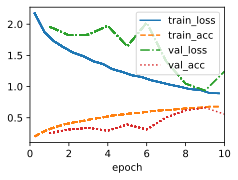

In [17]:
modelBNGoogleNet = BNGoogleNet(lr=0.01)
modelBNGoogleNet.apply_init([next(iter(data.get_dataloader(True)))[0]], 
                          d2l.init_cnn)
trainerGoogleNet.fit(modelBNGoogleNet, data)

# Problem 3 - ResNet

### ResNet Baseline

In [18]:
# Define a residual block
class Residual(nn.Module):
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [19]:
# Define ResNet model
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

In [20]:
# Define ResNet-18
class ResNet18(ResNet):
  def __init__(self, lr=0.1, num_classes=10):
    super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                    lr, num_classes)
ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


In [21]:
trainerResNet = d2l.Trainer(max_epochs=10, num_gpus=2)
data = CIFAR10(batch_size=128, resize=(64, 64))

Files already downloaded and verified
Files already downloaded and verified


120.36 sec


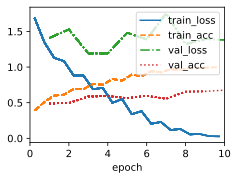

In [22]:
modelResNet18 = ResNet18(lr=0.01)
modelResNet18.apply_init([next(iter(data.get_dataloader(True)))[0]], 
                         d2l.init_cnn)
tic = time.time()
trainerResNet.fit(modelResNet18, data)
print(f'{time.time() - tic:.2f} sec')

In [23]:
with torch.cuda.device(0):  
  nets = [modelResNet18]
  for net in nets:
    macs, params = get_model_complexity_info(net, (3, 64, 64), 
                      as_strings=True, print_per_layer_stat=False, 
                      verbose=False)
    print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
    print('{:<30}  {:<8}'.format('Number of parameters: ', params))
    print('---------------------')

Computational complexity:       148.76 MMac
Number of parameters:           11.18 M 
---------------------


### ResNet 26 and 32

In [24]:
# Define ResNet-26
class ResNet26(ResNet):
  def __init__(self, lr=0.1, num_classes=10):
    super().__init__(((2, 64), (4, 128), (4, 256), (2, 512)),
                    lr, num_classes)
ResNet26().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


141.35 sec


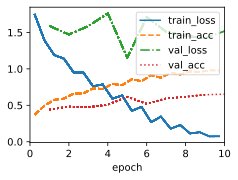

In [25]:
modelResNet26 = ResNet26(lr=0.01)
modelResNet26.apply_init([next(iter(data.get_dataloader(True)))[0]], 
                         d2l.init_cnn)
tic = time.time()
trainerResNet.fit(modelResNet26, data)
print(f'{time.time() - tic:.2f} sec')

In [26]:
# Define ResNet-32
class ResNet32(ResNet):
  def __init__(self, lr=0.1, num_classes=10):
    super().__init__(((3, 64), (4, 128), (6, 256), (2, 512)),
                    lr, num_classes)
ResNet26().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


161.82 sec


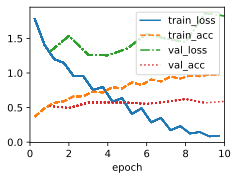

In [27]:
modelResNet32 = ResNet32(lr=0.01)
modelResNet32.apply_init([next(iter(data.get_dataloader(True)))[0]], 
                         d2l.init_cnn)
tic = time.time()
trainerResNet.fit(modelResNet32, data)
print(f'{time.time() - tic:.2f} sec')

In [28]:
with torch.cuda.device(0):  
  nets = [modelResNet18, modelResNet26, modelResNet32]
  for net in nets:
    macs, params = get_model_complexity_info(net, (3, 64, 64), 
                      as_strings=True, print_per_layer_stat=False, 
                      verbose=False)
    print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
    print('{:<30}  {:<8}'.format('Number of parameters: ', params))
    print('---------------------')

Computational complexity:       148.76 MMac
Number of parameters:           11.18 M 
---------------------
Computational complexity:       224.41 MMac
Number of parameters:           14.14 M 
---------------------
Computational complexity:       281.18 MMac
Number of parameters:           16.57 M 
---------------------
